# ASSIGNMENT 1
## BANDIT LEARNING ALGORITHM

DSCI 6650-001: Reinforcement Learning

Student: Sahil Khan

Date: 18-JUNE-2025
________________________________________________________________________________

In [16]:
# import library

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)

# global parameters for the experiment
kArms = 10              # the number of arms slot machines
timeSteps = 2000          # the number of times we play in a single run
numSimulations = 1000   # the number of times we repeat the experiment to get smooth averages

# parameters for part 2
driftStdDev = 0.01      # standard deviation for the random walk in gradual changes
meanRevertKappa = 0.5   # mean reversion parameter
abruptChangeStep = 501  # the timestep at which the means are shuffled

In [17]:
class BanditEnvironment:
    def __init__(self, k, numSims, mode='stationary', seed=None):
        """
        initialize bandit environment
        k: number of arms
        numSims: number of simulations
        mode: 'stationary', 'drift', 'mean_revert', or 'abrupt'
        seed: random seed for reproducibility
        """
        if seed is not None:
            np.random.seed(seed)

        self.k = k
        self.numSims = numSims
        self.mode = mode

        # create the true hidden mean reward for each arm for each simulation
        self.initialTrueMeans = np.random.normal(0, 1, (numSims, k))
        self.trueMeans = np.copy(self.initialTrueMeans)

        # if the mode is abrupt create a fixed random permutation
        if self.mode == 'abrupt':
            self.permutation = np.random.permutation(k)

    def getOptimalActions(self):
        """returns the index of the best possible arm for each simulation"""
        return np.argmax(self.trueMeans, axis=1)

    def getOptimisticInitialValue(self):
        """calculate 99.5th percentile of normal distribution with highest mean"""
        maxMeans = np.max(self.initialTrueMeans, axis=1)
        # 99.5th percentile of N(mu_max, 1) is mu_max + 2.576
        return np.mean(maxMeans + 2.576)

    def step(self, actions, t):
        """takes an action provides a reward and updates the environment if non stationary"""
        # first update the environment based on the mode
        if self.mode == 'drift':
            drift = np.random.normal(0, driftStdDev, (self.numSims, self.k))
            self.trueMeans += drift

        elif self.mode == 'mean_revert':
            noise = np.random.normal(0, driftStdDev, (self.numSims, self.k))
            self.trueMeans = meanRevertKappa * self.trueMeans + noise

        elif self.mode == 'abrupt' and t == abruptChangeStep:
            self.trueMeans = self.trueMeans[:, self.permutation]

        # then generate rewards for the chosen actions
        meansForActions = self.trueMeans[np.arange(self.numSims), actions]
        return np.random.normal(meansForActions, 1)

In [19]:
def runEpsilonGreedy(environment, epsilon, qInitial, stepSize=None, resetAt=None):
    k = environment.k
    numSims = environment.numSims

    # agents memory
    qEstimates = np.full((numSims, k), qInitial, dtype=float)
    actionCounts = np.zeros((numSims, k))

    # storing results
    rewardsHistory = []
    optimalActionHistory = []

    for t in tqdm(range(timeSteps), desc=f"Eps-Greedy(ε={epsilon}, Q₁={qInitial:.1f})"):
        # optional hard reset for part 2
        if resetAt is not None and t == resetAt:
            qEstimates.fill(0.0) # Assignment asks to reset to 0
            actionCounts.fill(0)

        # action selection
        actions = np.zeros(numSims, dtype=int)
        for sim in range(numSims):
            if np.random.rand() < epsilon:
                actions[sim] = np.random.randint(k)
            else:
                maxActions = np.where(qEstimates[sim] == np.max(qEstimates[sim]))[0]
                actions[sim] = np.random.choice(maxActions)

        # environment step
        rewards = environment.step(actions, t)

        # update agents beliefs
        simIndices = np.arange(numSims)
        actionCounts[simIndices, actions] += 1
        alpha = 1.0 / actionCounts[simIndices, actions] if stepSize is None else stepSize
        oldQ = qEstimates[simIndices, actions]
        qEstimates[simIndices, actions] = oldQ + alpha * (rewards - oldQ)

        # record results
        rewardsHistory.append(np.mean(rewards))
        optimalActionHistory.append(np.mean(actions == environment.getOptimalActions()))

    return np.array(rewardsHistory), np.array(optimalActionHistory)

In [20]:
def runGradientBandit(environment, alpha, useBaseline=True, resetAt=None):
    k = environment.k
    numSims = environment.numSims

    # agents memory preferences h
    preferences = np.zeros((numSims, k), dtype=float)
    avgReward = np.zeros(numSims)

    # storing results
    rewardsHistory = []
    optimalActionHistory = []

    for t in tqdm(range(timeSteps), desc=f"Gradient Bandit(α={alpha})"):
        # optional hard reset for part 2
        if resetAt is not None and t == resetAt:
            preferences.fill(0.0)
            avgReward.fill(0)

        # action selection softmax
        expPrefs = np.exp(preferences - np.max(preferences, axis=1, keepdims=True))
        actionProbs = expPrefs / np.sum(expPrefs, axis=1, keepdims=True)
        actions = np.array([np.random.choice(k, p=p) for p in actionProbs])

        # environment step
        rewards = environment.step(actions, t)

        # update agents beliefs
        baseline = avgReward if useBaseline else 0

        # update preferences for all actions
        for a in range(k):
            isChosenAction = (actions == a)
            preferences[:, a] += alpha * (rewards - baseline) * (isChosenAction - actionProbs[:, a])

        # update average reward baseline
        if useBaseline:
            avgReward += 0.1 * (rewards - avgReward)

        # record results
        rewardsHistory.append(np.mean(rewards))
        optimalActionHistory.append(np.mean(actions == environment.getOptimalActions()))

    return np.array(rewardsHistory), np.array(optimalActionHistory)

In [22]:
#HyperparameterTuning

def runPilotExperiments():
    """run pilot experiments to find good hyperparameters"""
    print("--- Running Pilot Experiments for Hyperparameter Tuning ---")

    # test different epsilon values
    epsilonValues = [0.01, 0.05, 0.1, 0.15, 0.2]
    alphaValues = [0.05, 0.1, 0.2, 0.3, 0.4]

    print("\nTesting epsilon values for epsilon-greedy...")
    bestEpsilon = 0.1
    bestEpsilonReward = -float('inf')

    for eps in epsilonValues:
        # use a smaller, faster simulation for tuning
        tempEnv = BanditEnvironment(kArms, 200, mode='stationary', seed=123)
        rewards, _ = runEpsilonGreedy(tempEnv, eps, 0.0)
        avgReward = np.mean(rewards[-200:]) # average of last 200 steps
        print(f"Epsilon {eps}: Average reward = {avgReward:.3f}")
        if avgReward > bestEpsilonReward:
            bestEpsilonReward = avgReward
            bestEpsilon = eps

    print(f"\n=> Best epsilon found: {bestEpsilon}")

    print("\nTesting alpha values for gradient bandit...")
    bestAlpha = 0.1
    bestAlphaReward = -float('inf')

    for alpha in alphaValues:
        tempEnv = BanditEnvironment(kArms, 200, mode='stationary', seed=123)
        rewards, _ = runGradientBandit(tempEnv, alpha)
        avgReward = np.mean(rewards[-200:])
        print(f"Alpha {alpha}: Average reward = {avgReward:.3f}")
        if avgReward > bestAlphaReward:
            bestAlphaReward = avgReward
            bestAlpha = alpha

    print(f"\n=> Best alpha found: {bestAlpha}")

    return bestEpsilon, bestAlpha

bestEpsilon, bestAlpha = runPilotExperiments()

--- Running Pilot Experiments for Hyperparameter Tuning ---

Testing epsilon values for epsilon-greedy...


Eps-Greedy(ε=0.01, Q₁=0.0): 100%|██████████| 2000/2000 [00:06<00:00, 288.55it/s]


Epsilon 0.01: Average reward = 1.354


Eps-Greedy(ε=0.05, Q₁=0.0): 100%|██████████| 2000/2000 [00:06<00:00, 308.18it/s]


Epsilon 0.05: Average reward = 1.386


Eps-Greedy(ε=0.1, Q₁=0.0): 100%|██████████| 2000/2000 [00:06<00:00, 320.21it/s]


Epsilon 0.1: Average reward = 1.314


Eps-Greedy(ε=0.15, Q₁=0.0): 100%|██████████| 2000/2000 [00:05<00:00, 335.81it/s]


Epsilon 0.15: Average reward = 1.254


Eps-Greedy(ε=0.2, Q₁=0.0): 100%|██████████| 2000/2000 [00:05<00:00, 347.86it/s]


Epsilon 0.2: Average reward = 1.177

=> Best epsilon found: 0.05

Testing alpha values for gradient bandit...


Gradient Bandit(α=0.05): 100%|██████████| 2000/2000 [00:06<00:00, 293.31it/s]


Alpha 0.05: Average reward = 1.449


Gradient Bandit(α=0.1): 100%|██████████| 2000/2000 [00:06<00:00, 292.89it/s]


Alpha 0.1: Average reward = 1.441


Gradient Bandit(α=0.2): 100%|██████████| 2000/2000 [00:06<00:00, 289.23it/s]


Alpha 0.2: Average reward = 1.428


Gradient Bandit(α=0.3): 100%|██████████| 2000/2000 [00:06<00:00, 289.45it/s]


Alpha 0.3: Average reward = 1.416


Gradient Bandit(α=0.4): 100%|██████████| 2000/2000 [00:06<00:00, 292.08it/s]

Alpha 0.4: Average reward = 1.399

=> Best alpha found: 0.05


In [23]:
# p1 - Run Stationary Simulations

print("\n--- Running Part 1: Stationary Environment ---")

# create the stationary environment
envPart1 = BanditEnvironment(kArms, numSimulations, mode='stationary', seed=42)
optimisticValue = envPart1.getOptimisticInitialValue()

print(f"Using optimistic initial value: {optimisticValue:.3f}")
print(f"Using best epsilon from pilot: {bestEpsilon}")
print(f"Using best alpha from pilot: {bestAlpha}")

# run simulations for each algorithm
resultsPart1 = {}
resultsPart1['Greedy ε=0'] = runEpsilonGreedy(envPart1, epsilon=0, qInitial=0.0)
resultsPart1[f'Optimistic Q₁={optimisticValue:.1f}'] = runEpsilonGreedy(envPart1, epsilon=0, qInitial=optimisticValue)
resultsPart1[f'Epsilon-Greedy ε={bestEpsilon}'] = runEpsilonGreedy(envPart1, epsilon=bestEpsilon, qInitial=0.0)
resultsPart1[f'Gradient Bandit α={bestAlpha}'] = runGradientBandit(envPart1, alpha=bestAlpha)

print("\n--- All stationary simulations complete ---")


--- Running Part 1: Stationary Environment ---
Using optimistic initial value: 4.128
Using best epsilon from pilot: 0.05
Using best alpha from pilot: 0.05


Gradient Bandit(α=0.05): 100%|██████████| 2000/2000 [00:32<00:00, 61.85it/s]


--- All stationary simulations complete ---


/tmp/ipython-input-24-2370694973.py:29: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.tight_layout()


--- Plotting results for Part 1 ---


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


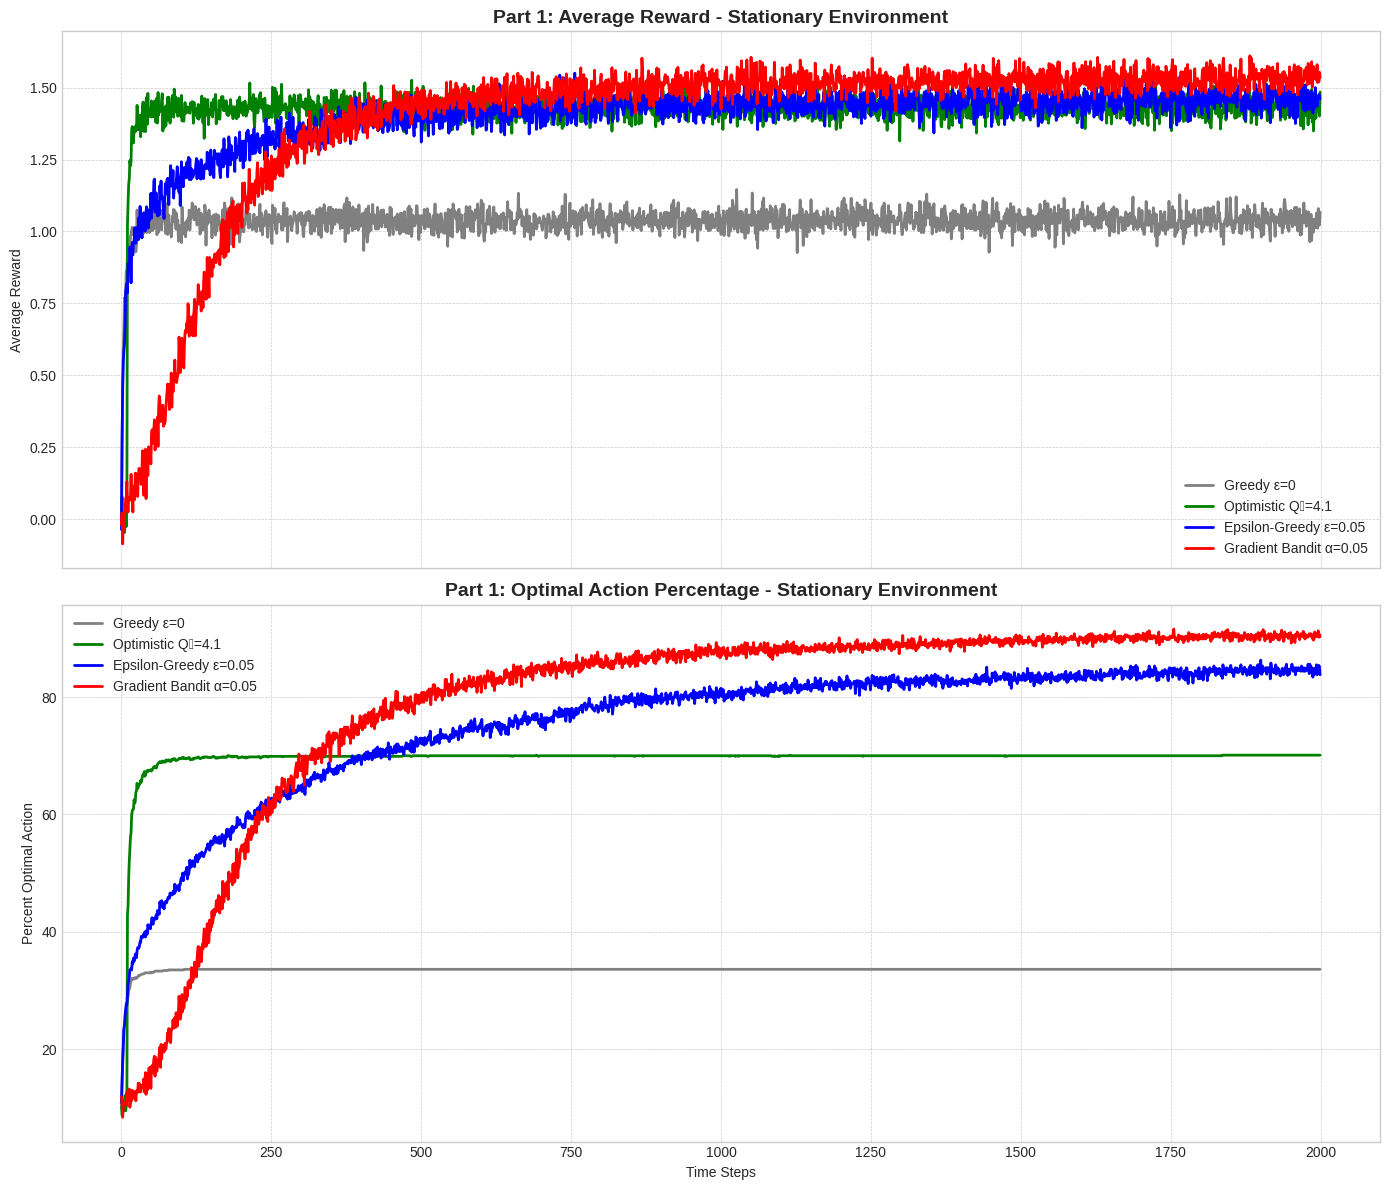

In [24]:
# p1 - Plot Results

print("--- Plotting results for Part 1 ---")

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
colors = ['grey', 'green', 'blue', 'red']
labels = list(resultsPart1.keys())

# plot 1: average reward
ax1.set_title("Part 1: Average Reward - Stationary Environment", fontsize=14, fontweight='bold')
ax1.set_ylabel("Average Reward")
for i, label in enumerate(labels):
    rewards, _ = resultsPart1[label]
    ax1.plot(rewards, label=label, color=colors[i], linewidth=2)
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# plot 2: percent optimal action
ax2.set_title("Part 1: Optimal Action Percentage - Stationary Environment", fontsize=14, fontweight='bold')
ax2.set_ylabel("Percent Optimal Action")
ax2.set_xlabel("Time Steps")
for i, label in enumerate(labels):
    _, optimals = resultsPart1[label]
    ax2.plot(optimals * 100, label=label, color=colors[i], linewidth=2)
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [25]:
# p2.1 - Run Gradual Change Simulations

print("\n--- Running Part 2.1: Non-Stationary with Gradual Changes ---")

# test both drift and mean-reverting models
print("Testing drift model...")
envPart2Drift = BanditEnvironment(kArms, numSimulations, mode='drift', seed=42)
resultsPart2Drift = {}
resultsPart2Drift['Epsilon-Greedy (drift)'] = runEpsilonGreedy(envPart2Drift, epsilon=bestEpsilon, qInitial=0.0, stepSize=0.1)
resultsPart2Drift['Gradient Bandit (drift)'] = runGradientBandit(envPart2Drift, alpha=bestAlpha)

print("\nTesting mean-reverting model...")
envPart2MeanRevert = BanditEnvironment(kArms, numSimulations, mode='mean_revert', seed=42)
resultsPart2MeanRevert = {}
resultsPart2MeanRevert['Epsilon-Greedy (mean-revert)'] = runEpsilonGreedy(envPart2MeanRevert, epsilon=bestEpsilon, qInitial=0.0, stepSize=0.1)
resultsPart2MeanRevert['Gradient Bandit (mean-revert)'] = runGradientBandit(envPart2MeanRevert, alpha=bestAlpha)

print("\n--- Gradual changes simulations complete ---")


--- Running Part 2.1: Non-Stationary with Gradual Changes ---
Testing drift model...


Gradient Bandit(α=0.05): 100%|██████████| 2000/2000 [00:33<00:00, 60.11it/s]



Testing mean-reverting model...


Gradient Bandit(α=0.05): 100%|██████████| 2000/2000 [00:32<00:00, 61.11it/s]


--- Gradual changes simulations complete ---


--- Plotting results for Part 2.1 ---


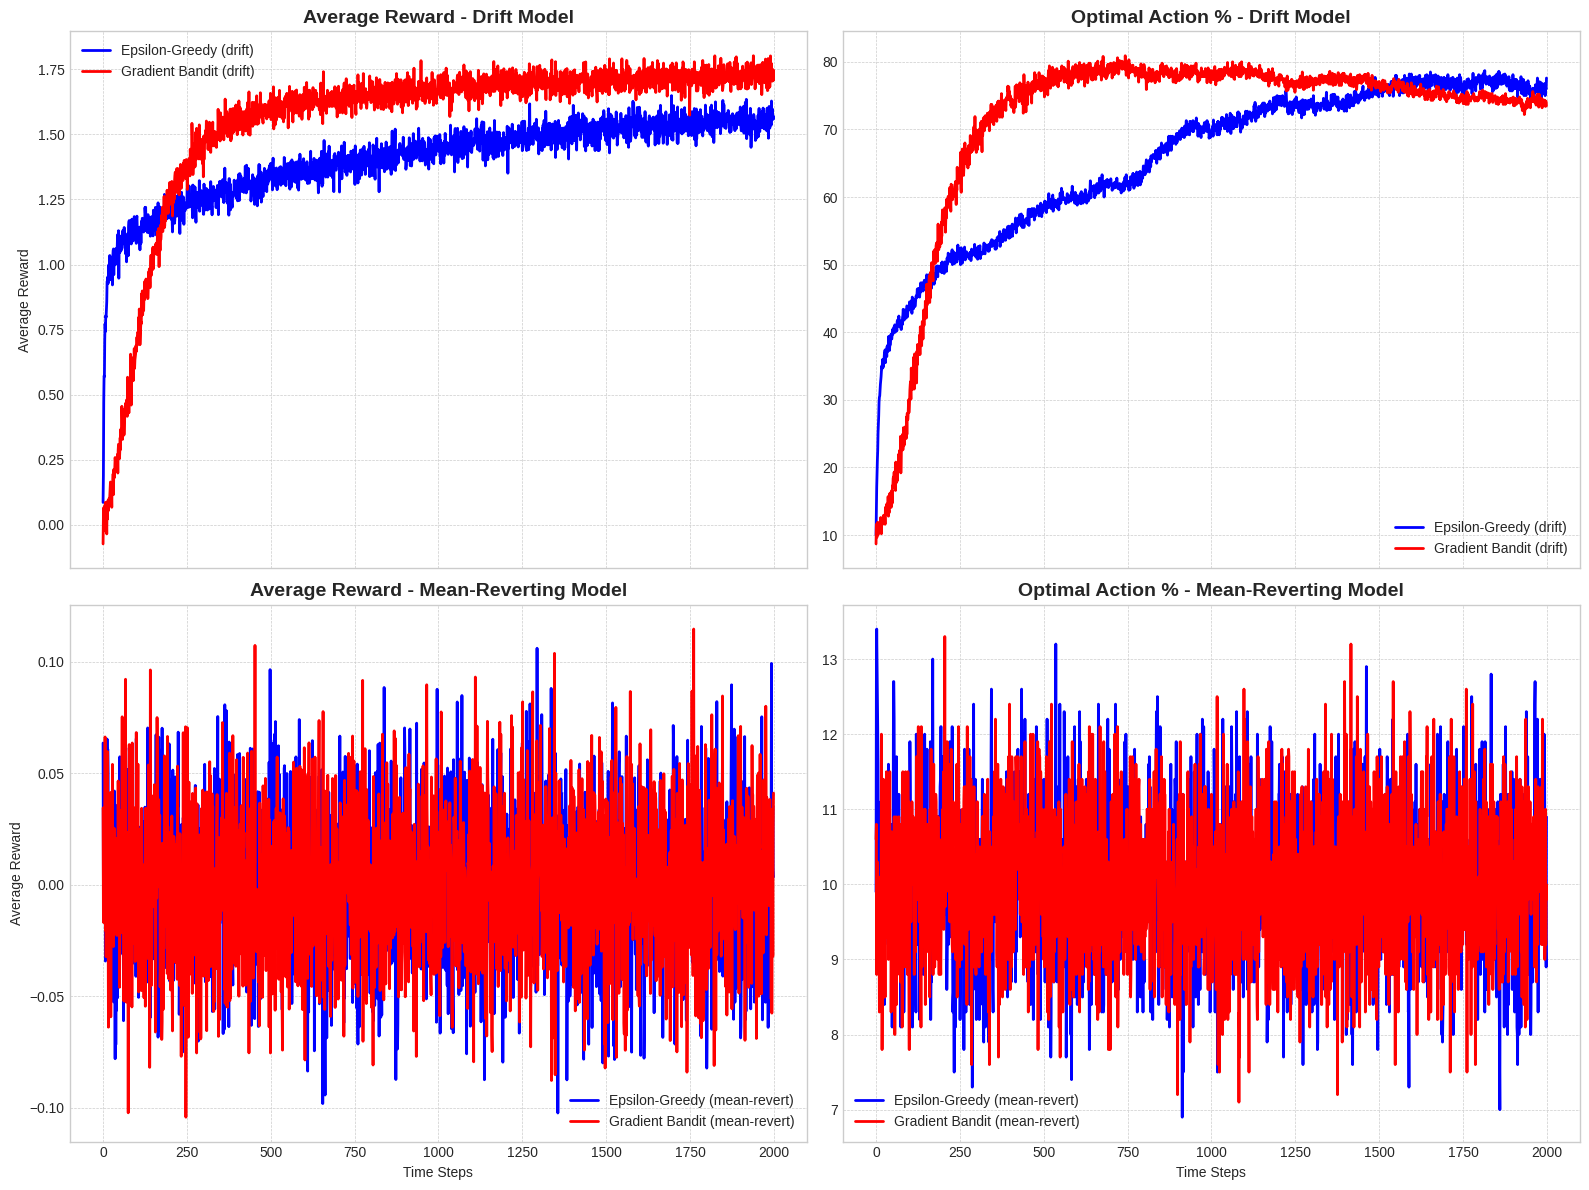

In [26]:
# p2.1 - Plot Gradual Change Results

print("--- Plotting results for Part 2.1 ---")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
colors = ['blue', 'red']
drift_labels = list(resultsPart2Drift.keys())
mean_revert_labels = list(resultsPart2MeanRevert.keys())

# drift model plots
ax1.set_title("Average Reward - Drift Model", fontsize=14, fontweight='bold')
ax1.set_ylabel("Average Reward")
for i, label in enumerate(drift_labels):
    rewards, _ = resultsPart2Drift[label]
    ax1.plot(rewards, label=label, color=colors[i], linewidth=2)
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

ax2.set_title("Optimal Action % - Drift Model", fontsize=14, fontweight='bold')
for i, label in enumerate(drift_labels):
    _, optimals = resultsPart2Drift[label]
    ax2.plot(optimals * 100, label=label, color=colors[i], linewidth=2)
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# mean-reverting model plots
ax3.set_title("Average Reward - Mean-Reverting Model", fontsize=14, fontweight='bold')
ax3.set_ylabel("Average Reward")
ax3.set_xlabel("Time Steps")
for i, label in enumerate(mean_revert_labels):
    rewards, _ = resultsPart2MeanRevert[label]
    ax3.plot(rewards, label=label, color=colors[i], linewidth=2)
ax3.legend()
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)

ax4.set_title("Optimal Action % - Mean-Reverting Model", fontsize=14, fontweight='bold')
ax4.set_xlabel("Time Steps")
for i, label in enumerate(mean_revert_labels):
    _, optimals = resultsPart2MeanRevert[label]
    ax4.plot(optimals * 100, label=label, color=colors[i], linewidth=2)
ax4.legend()
ax4.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [27]:
# p2.2 - Run Abrupt Change Simulations

print("\n--- Running Part 2.2: Non-Stationary with Abrupt Changes ---")

# run algorithms as-is (no reset)
print("Running as-is simulations (no reset)...")
envAbruptAsis = BanditEnvironment(kArms, numSimulations, mode='abrupt', seed=42)
resultsPart2Asis = {}
resultsPart2Asis['Epsilon-Greedy (as-is)'] = runEpsilonGreedy(envAbruptAsis, epsilon=bestEpsilon, qInitial=0.0, stepSize=0.1)
resultsPart2Asis['Gradient Bandit (as-is)'] = runGradientBandit(envAbruptAsis, alpha=bestAlpha)

# run algorithms with hard reset
print("\nRunning hard reset simulations...")
envAbruptReset = BanditEnvironment(kArms, numSimulations, mode='abrupt', seed=42)
resultsPart2Reset = {}
resultsPart2Reset['Epsilon-Greedy (reset)'] = runEpsilonGreedy(envAbruptReset, epsilon=bestEpsilon, qInitial=0.0, stepSize=0.1, resetAt=abruptChangeStep)
resultsPart2Reset['Gradient Bandit (reset)'] = runGradientBandit(envAbruptReset, alpha=bestAlpha, resetAt=abruptChangeStep)

print("\n--- Abrupt changes simulations complete ---")


--- Running Part 2.2: Non-Stationary with Abrupt Changes ---
Running as-is simulations (no reset)...


Gradient Bandit(α=0.05): 100%|██████████| 2000/2000 [00:32<00:00, 61.43it/s]



Running hard reset simulations...


Gradient Bandit(α=0.05): 100%|██████████| 2000/2000 [00:32<00:00, 61.51it/s]


--- Abrupt changes simulations complete ---


--- Plotting results for Part 2.2 ---


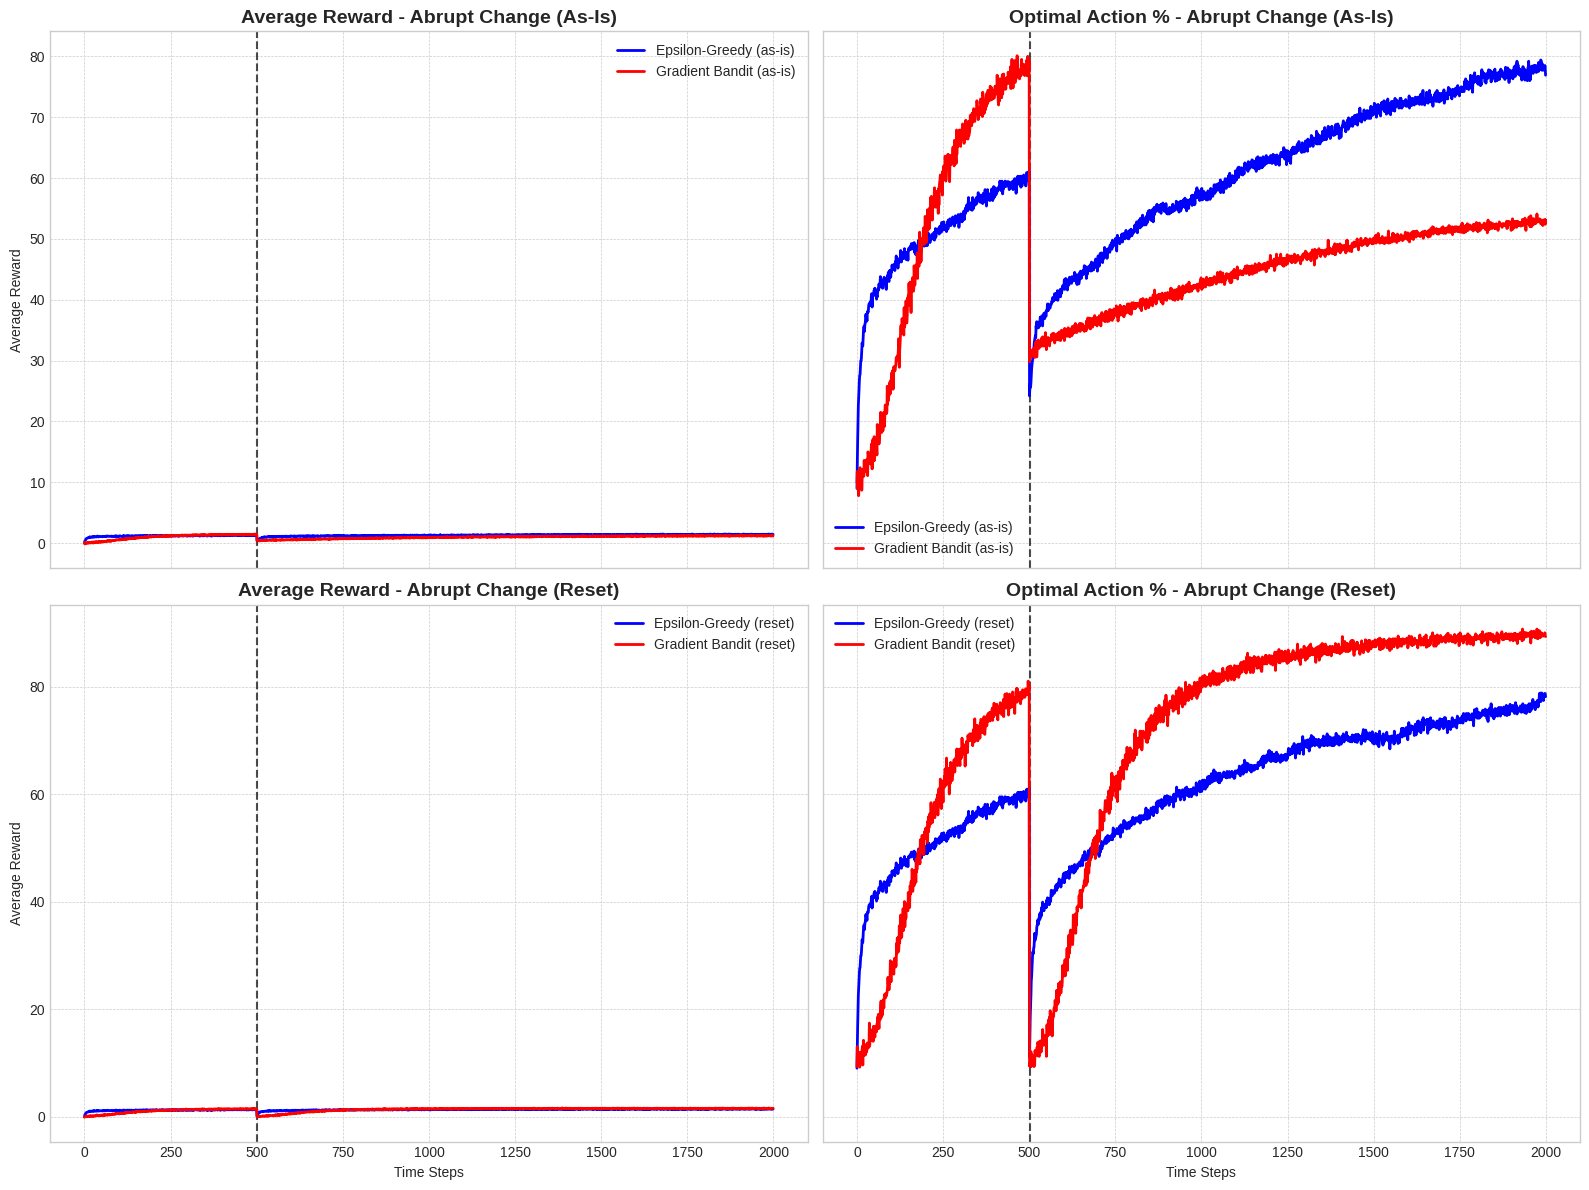


--- All simulations complete! ---


In [28]:
# p2.2 - Plot Abrupt Change Results

print("--- Plotting results for Part 2.2 ---")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey='row')
colors = ['blue', 'red']
asis_labels = list(resultsPart2Asis.keys())
reset_labels = list(resultsPart2Reset.keys())

# as-is plots
ax1.set_title("Average Reward - Abrupt Change (As-Is)", fontsize=14, fontweight='bold')
ax1.set_ylabel("Average Reward")
ax1.axvline(x=abruptChangeStep, color='black', linestyle='--', alpha=0.7)
for i, label in enumerate(asis_labels):
    rewards, _ = resultsPart2Asis[label]
    ax1.plot(rewards, label=label, color=colors[i], linewidth=2)
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

ax2.set_title("Optimal Action % - Abrupt Change (As-Is)", fontsize=14, fontweight='bold')
ax2.axvline(x=abruptChangeStep, color='black', linestyle='--', alpha=0.7)
for i, label in enumerate(asis_labels):
    _, optimals = resultsPart2Asis[label]
    ax2.plot(optimals * 100, label=label, color=colors[i], linewidth=2)
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# reset plots
ax3.set_title("Average Reward - Abrupt Change (Reset)", fontsize=14, fontweight='bold')
ax3.set_ylabel("Average Reward")
ax3.set_xlabel("Time Steps")
ax3.axvline(x=abruptChangeStep, color='black', linestyle='--', alpha=0.7)
for i, label in enumerate(reset_labels):
    rewards, _ = resultsPart2Reset[label]
    ax3.plot(rewards, label=label, color=colors[i], linewidth=2)
ax3.legend()
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)

ax4.set_title("Optimal Action % - Abrupt Change (Reset)", fontsize=14, fontweight='bold')
ax4.set_xlabel("Time Steps")
ax4.axvline(x=abruptChangeStep, color='black', linestyle='--', alpha=0.7)
for i, label in enumerate(reset_labels):
    _, optimals = resultsPart2Reset[label]
    ax4.plot(optimals * 100, label=label, color=colors[i], linewidth=2)
ax4.legend()
ax4.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n--- All simulations complete! ---")